In [1]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from darts import TimeSeries
from darts.datasets import AirPassengersDataset

In [108]:
df = pd.read_csv("20230411_SummerTerm23_Data_Challenge_Infineon_Data.csv", parse_dates=['reporting_time'])
df = df.set_index('reporting_time')
df = df[df['planning_method_latest']!='no Plan']
df[['demand', 'demand_lb', 'demand_ub']].describe()


,demand,demand_lb,demand_ub
count,6.175600e+04,6.175600e+04,6.175600e+04
mean,9.732063e+04,5.958392e+04,1.371627e+05
std,3.551535e+05,2.417415e+05,4.942232e+05
min,0.000000e+00,0.000000e+00,0.000000e+00
25%,0.000000e+00,0.000000e+00,0.000000e+00
50%,3.800000e+03,0.000000e+00,6.000000e+03
75%,5.217700e+04,2.496000e+04,7.500000e+04
max,1.575881e+07,1.344800e+07,1.740668e+07


In [97]:
#Getting all products with more than 18 months of data
no_month = 18
sub_df = df[df.groupby('product_name').product_name.transform('count')>=no_month].copy()
sub_df.product_name.value_counts()

P1817    54
P355     54
P290     54
P291     54
P298     54
         ..
P1384    18
P1398    18
P1400    18
P1401    18
P374     18
Name: product_name, Length: 1250, dtype: int64

<Axes: >

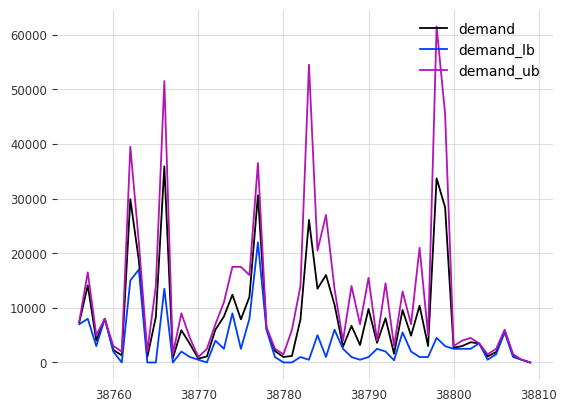

In [98]:
test_df = df[df['product_name']=='P1863']
test_df[['demand', 'demand_lb', 'demand_ub']].plot()

In [100]:
# #EDA report 
# from pandas_profiling import ProfileReport
# profile = ProfileReport(test_df, tsmode=True, )
# profile.to_file('profile_report.html')

In [101]:
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
def adf_test(data, columns):
    print('Results of ADF Test')
    for name in columns:
        print(f'\nResults for {name}:')
        df_test=adfuller(data[f'{name}'])
        print(f'adfuller statistic:\t{df_test[0]}')
        print(f'p-value:\t\t{df_test[1]}')
        print(f'lags used:\t\t{df_test[2]}')
        print(f'Critical values:')
        print(f'1%:\t\t\t{df_test[4]["1%"]}')
        print(f'5%:\t\t\t{df_test[4]["5%"]}')
        print(f'10%:\t\t\t{df_test[4]["10%"]}')

In [127]:
adf_test(test_df, columns=['demand', 'demand_lb', 'demand_ub'])

Results of ADF Test

Results for demand:
adfuller statistic:	-5.924352034422764
p-value:		2.463772097867599e-07
lags used:		0
Critical values:
1%:			-3.560242358792829
5%:			-2.9178502070837
10%:			-2.5967964150943397

Results for demand_lb:
adfuller statistic:	-5.862086006191265
p-value:		3.3917696675886386e-07
lags used:		0
Critical values:
1%:			-3.560242358792829
5%:			-2.9178502070837
10%:			-2.5967964150943397

Results for demand_ub:
adfuller statistic:	-5.768205284487792
p-value:		5.469602411848685e-07
lags used:		0
Critical values:
1%:			-3.560242358792829
5%:			-2.9178502070837
10%:			-2.5967964150943397


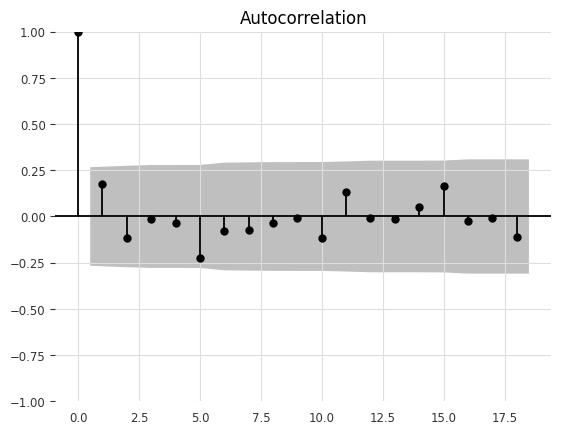

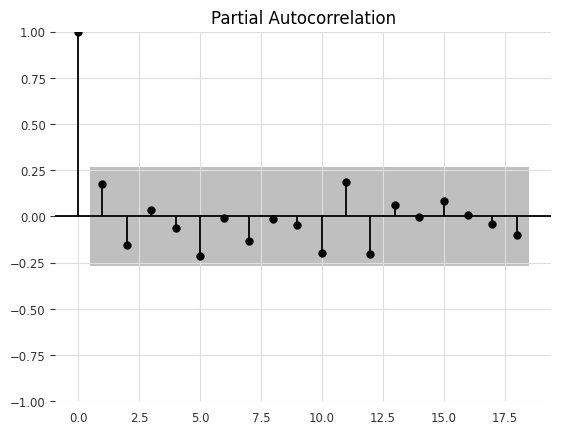

In [128]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf

acf=plot_acf(test_df.demand)
pacf=plot_pacf(test_df.demand.dropna())

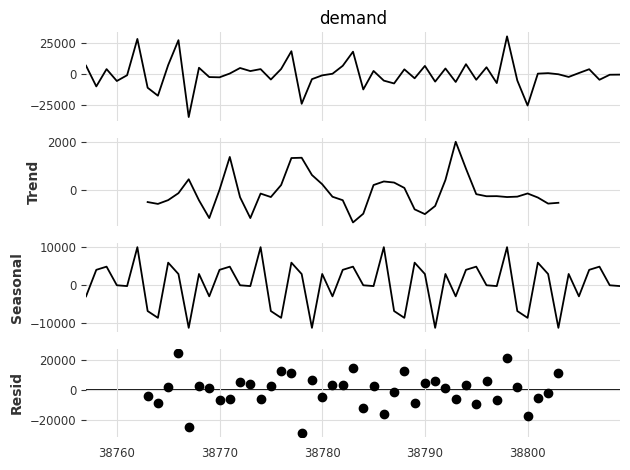

In [119]:
from statsmodels.tsa.seasonal import seasonal_decompose
decompose_res = seasonal_decompose(test_df.demand, model = 'additive', period=12)
trend = decompose_res.trend
seasonal = decompose_res.seasonal
residual = decompose_res.resid
decomplot = decompose_res.plot()

In [121]:
# https://knk00.medium.com/how-to-determine-seasonality-without-plots-f18cee913b95
from scipy.stats import kruskal

def seasonality_test(df, columns, periods):
    my_dict = {}
    idx = np.arange(len(df.index)) % 12
    for name in columns:
        my_dict[name] = False
        H_statistic, p_value = kruskal(df[f'{name}'], idx)
        if p_value <= 0.05:
            seasonal = True
            my_dict[name] = seasonal
    return my_dict
    

In [129]:
seasonality_test(df = test_df[['demand', 'demand_lb', 'demand_ub']].diff().dropna(), columns=['demand', 'demand_lb', 'demand_ub'], periods=12)

{'demand': False, 'demand_lb': True, 'demand_ub': False}

In [133]:
from darts.models import AutoARIMA, ExponentialSmoothing, TBATS, Theta, NBEATSModel
from darts.metrics import smape
from darts.utils.utils import SeasonalityMode

train = 0.7
val = 0.2
test = 0.1


length = len(test_df)
darts_df = TimeSeries.from_series(test_df.demand)

train_set, val_test= darts_df.split_before(train)
# train_set
val_set, test_set = val_test.split_before(2/3)
# val_set

def eval_model(model, train, val):
    model.fit(train)
    forecast=model.predict(len(val))
    print("model {} obtains MAPE: {:.2f}%".format(model, smape(val, forecast)))

model_list = [ExponentialSmoothing(), AutoARIMA(), TBATS(), Theta(season_mode = SeasonalityMode.ADDITIVE)]
# eval_model(model=AutoARIMA(), train=train_set, val=val_set)
for model in model_list:
    eval_model(model=model, train=train_set, val=val_set)

c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


model ExponentialSmoothing() obtains MAPE: 110.64%
model AutoARIMA() obtains MAPE: 83.20%
model TBATS() obtains MAPE: 74.66%
model Theta(season_mode=SeasonalityMode.ADDITIVE) obtains MAPE: 89.80%


c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\statsmodels\tsa\holtwinters\model.py:917: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(
c:\Users\melov\Documents\GitHub\tum_DAP_project\venv\lib\site-packages\darts\models\forecasting\theta.py:161: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  self.seasonality.pd_series()[-self.season_period :],
